In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

**Step 0: Import CSV File**

In [3]:
file_path = "./vessel_movements/vessel_movements_PPT.csv"

vessel_df = pd.read_csv(file_path)
display(vessel_df.head())

,imo,mmsi,vessel_id,vessel_name,date_of_build,vessel_type,group,timestamp,date_only,lon,...,anchorage,terminal,maneuvering_zone,p,vref,sfc_me,sfc_ae,sfc_ab,ael,abl
0,9223253,525119038,692017,PRIMA TANGGUH LVI,2002-04-01,Crude/Oil Products Tanker,Crude & Products Tanker,2023-09-17T00:01:42.000Z,2023-09-17,103.826065,...,PPT Anchorage,NaN,NaN,7860.0,14.5,185.0,230.0,300.0,507.0,365.0
1,9223253,525119038,692017,PRIMA TANGGUH LVI,2002-04-01,Crude/Oil Products Tanker,Crude & Products Tanker,2023-09-17T00:01:44.000Z,2023-09-17,103.826065,...,PPT Anchorage,NaN,NaN,7860.0,14.5,185.0,230.0,300.0,507.0,365.0
2,9223253,525119038,692017,PRIMA TANGGUH LVI,2002-04-01,Crude/Oil Products Tanker,Crude & Products Tanker,2023-09-17T00:07:43.000Z,2023-09-17,103.825690,...,PPT Anchorage,NaN,NaN,7860.0,14.5,185.0,230.0,300.0,507.0,365.0
3,9223253,525119038,692017,PRIMA TANGGUH LVI,2002-04-01,Crude/Oil Products Tanker,Crude & Products Tanker,2023-09-17T00:07:45.000Z,2023-09-17,103.825690,...,PPT Anchorage,NaN,NaN,7860.0,14.5,185.0,230.0,300.0,507.0,365.0
4,9223253,525119038,692017,PRIMA TANGGUH LVI,2002-04-01,Crude/Oil Products Tanker,Crude & Products Tanker,2023-09-17T00:10:42.000Z,2023-09-17,103.825580,...,PPT Anchorage,NaN,NaN,7860.0,14.5,185.0,230.0,300.0,507.0,365.0


**Step 0.5: Clean the dataset**

In [4]:
# Change speed null to 0
vessel_df['speed'] = vessel_df['speed'].fillna(0.0)

# remove 120273 data that is NA for "anchorage","berth", "maneuvering_zone"
vessel_df = vessel_df[~vessel_df.loc[:, ["anchorage","berth", "maneuvering_zone"]].isna().all(1)]

print(vessel_df[["anchorage", "berth", "maneuvering_zone"]].isna().all(axis=1).sum() == 0)

True



**Step 1: Determine the operating mode of the vessel at each AIS data point**

In [5]:
conditions = [
    ((vessel_df['speed'] > 1) | vessel_df['nav_stat'].isin([0, 3, 4, 8, 11, 12])) & vessel_df['maneuvering_zone'].isnull(),  
    (vessel_df['anchorage'] == 'PPT Anchorage') & (vessel_df['speed'] < 1),  
    ((vessel_df['speed'] > 1) | vessel_df['nav_stat'].isin([0, 3, 4, 8, 11, 12])) & (vessel_df['maneuvering_zone'] == 'PPT Maneouvering Zone'),  
    (vessel_df['berth'].notnull()) & (vessel_df['speed'] < 1)
]

# Define the corresponding values for each condition
values = [1, 2, 3, 4]

# Create the new column using numpy.select
vessel_df['operating_mode'] = np.select(conditions, values, default=0)
display(vessel_df['operating_mode'].head())

0    2
1    2
2    2
3    2
4    2
Name: operating_mode, dtype: int64

**Step 2: Log events at each timestamp**

The event duration is the difference between two consecutive timestamps for each vessel i.e. same IMO number. 

Note: If the difference between two AIS time stamps is more than 10,000 seconds, then the event is not continuous and should not undergo calculation for this greater than 24-hour period. Thereafter it should start afresh.

In [6]:
# Sort df by imo and timestamp
vessel_df = vessel_df.sort_values(['imo', 'timestamp'], ascending=[True, True]) 

# Calculate event duration
vessel_df['next_timestamp'] = vessel_df.groupby(['imo'])['timestamp'].shift(-1) 
vessel_df['event_duration'] = pd.to_datetime(vessel_df['next_timestamp']) - pd.to_datetime(vessel_df['timestamp'])
vessel_df['event_duration_sec'] = vessel_df['event_duration'].dt.total_seconds()

# Remove "restart" values
vessel_df.loc[vessel_df['event_duration_sec'] > 10000, 'event_duration_sec'] = 0

print(~(vessel_df['event_duration_sec'] > 10000).any())
display(vessel_df.head())

True


,imo,mmsi,vessel_id,vessel_name,date_of_build,vessel_type,group,timestamp,date_only,lon,...,vref,sfc_me,sfc_ae,sfc_ab,ael,abl,operating_mode,next_timestamp,event_duration,event_duration_sec
2663186,1006946,319646000,660707,PARAFFIN,2001-10-01,Yacht,Other,2023-09-30T02:20:00.000Z,2023-09-30,103.783820,...,14.0,195.0,230.0,300.0,NaN,NaN,3,2023-09-30T02:20:41.000Z,0 days 00:00:41,41.0
2663185,1006946,319646000,660707,PARAFFIN,2001-10-01,Yacht,Other,2023-09-30T02:20:41.000Z,2023-09-30,103.786190,...,14.0,195.0,230.0,300.0,NaN,NaN,3,2023-09-30T02:25:08.000Z,0 days 00:04:27,267.0
2658468,1006946,319646000,660707,PARAFFIN,2001-10-01,Yacht,Other,2023-09-30T02:25:08.000Z,2023-09-30,103.802060,...,14.0,195.0,230.0,300.0,NaN,NaN,1,2023-09-30T02:25:40.000Z,0 days 00:00:32,32.0
2658467,1006946,319646000,660707,PARAFFIN,2001-10-01,Yacht,Other,2023-09-30T02:25:40.000Z,2023-09-30,103.803820,...,14.0,195.0,230.0,300.0,NaN,NaN,1,2023-09-30T02:30:08.000Z,0 days 00:04:28,268.0
2658466,1006946,319646000,660707,PARAFFIN,2001-10-01,Yacht,Other,2023-09-30T02:30:08.000Z,2023-09-30,103.818245,...,14.0,195.0,230.0,300.0,NaN,NaN,1,2023-09-30T02:31:10.000Z,0 days 00:01:02,62.0


**Step 3: Determine the vessel type**

In [7]:
# Define the OGV types
ogv_types = [
    'Crude & Products Tanker',
    'Chemical Tanker',
    'Container Ship',
    'General Cargo',
    'Passenger/Cruise',
    'Bulk Carrier',
    'Auto Carrier',
    'Reefer',
    'RoRo',
    'LPG Tanker'
]

# Create a new column 'is_ogv'
vessel_df['is_ogv'] = vessel_df['group'].apply(lambda x: x in ogv_types)

# Remove the 770493 columns that are not OGV
vessel_df = vessel_df[vessel_df['is_ogv'] == True]

print(~(vessel_df['is_ogv'] == False).any())

True


**Step 3.5: Clean Data**

In [8]:
# as seen, there are 2684 with the default value 0

#upon further insepction, the values fall under one of the 4 catagories
# Speed 0.0, nav_stat = 5 (Moored (tied to another object to limit free movement)), but maneuvering_zone = 'PPT Maneouvering Zone'     2323
# Speed 0.0, nav_stat = 1 (Anchored), but maneuvering_zone = 'PPT Maneouvering Zone'      218
# Speed 0.0, nav_stat = 15 (Undefined (default)), but maneuvering_zone = 'PPT Maneouvering Zone'     130
# Speed 0.0, nav_stat = 2 (Not under command), but maneuvering_zone = 'PPT Maneouvering Zone'       13

vessel_df = vessel_df[vessel_df['operating_mode'] != 0]

print(~(vessel_df['operating_mode'] == 0).any())

True


**Step 4: Determine Emissions Tier**

In [9]:
vessel_df["formatted_date"] = pd.to_datetime(vessel_df["date_of_build"], format="%Y-%m-%d")
vessel_df["model_year"] = vessel_df["formatted_date"].dt.year

# Split into bins: Pre-2000, 2000-2010, post 2010, 2011-2015, post 2015
# We need to consider BOTH fuel_category and model_year!
def update_value(row):
    my = row["model_year"]
    fc = row["fuel_category"]
    if my < 2000:
        return "Pre-2000"
    elif my >= 2000 and my < 2010:
        return "2000-2010"
    elif my >= 2010 and my < 2015 and fc == 3:
        return "2011-2015"
    elif my >= 2010 and my < 2015:
        return "post 2010"
    else:
        return "post 2015"

vessel_df["model_year_category"] = vessel_df.apply(update_value, axis=1)

def update_emission_tier(row):
    my = row["model_year_category"]
    if my == "Pre-2000":
        return 0 
    elif my == "2000-2010":
        return 1
    elif my == "post 2010":
        return 2
    elif my == "2011-2015":
        return 2 
    else: 
        return 3
    
vessel_df["emission_tier"] = vessel_df.apply(update_emission_tier, axis=1)
vessel_df = vessel_df.drop(columns=["formatted_date"])
display(vessel_df["emission_tier"].tail())

2679458    3
2687878    3
2687877    3
2687876    3
2679457    3
Name: emission_tier, dtype: int64

**Step 5: Determine Fuel Category**

Ports have defined fuel categories (e.g. High Sulphur, Global 0.5%, ECA).

For 2023, Singapore will fall under Global 2020.

**Step 6: Retrieve specific ship details for all vessels that are within the port boundary**
1. Main engine SFC (sfc_me)
2. Aux engine SFC (sfc_ae)
3. Auxiliary Boiler SFC (sfc_ab)

**Step 7: Calculate Emissions**

This step is dependent on the previous steps. Refer to below explanation for emission calculations

**Step 7a: Get the following parameters from the vessel movements data:**
* p
* Reference speed (vref)
* Actual speed (AS)

**Step 7b: Calculate maximum speed**

Formula:

>> Maximum Speed (MS) = 1.066 x vref

**Step 7c: Get activity hours (A) for each operating mode**

This was calculated in Step 2.

**Step 7d (i): Calculate Engine Load Factor (LF) for propulsion engines**

 >\\(LF =(AS/MS){^3}\\)
<br>Where</br> 
  LF = Load Factor
  <br>AS =  Actual speed (knots)</br>
    MS = Maximum speed (knots)

**Step 7d(ii): Look up Low Load Adjustment Factor (LLAF) using LF calculated in Step 7d(i)**

* Refer to llaf_table
* LLAF is not applicable if LF is more than 0.2. LLAF will be 1 in such cases.

Note: Propulsion engine emission can only be calculated for transit and maneuver modes since at other times the main engine is not running.

**Step 7e: If LF < 0.2 and mode is transit or maneuver, then LF will be defaulted to 0 .2.**

Note: this default is not applied when identifying LLAF

**Step 7f: Emission factor (EF) table is provided.  Singapore is a non-Emission Controlled Area (ECA) so Global 2020 rows are applicable. The EF table has some formulas applied for certain pollutants:**
<br>
1. NOx

* Refer to tables Propulsion Engine Emission Factors and Auxiliary Engine Emission Factors for main engine and auxiliary engine. The values used are dependent on Engine Type and Emissions Tier in vessel movements table.

* Do the same for Auxiliary Boiler (Boiler Engine Emission Factors table).

2. PM10 will be calculated as follows:
* Main Engine and Auxiliary Engine = 0.23 + (sfc_me or sfc_ae ) x 7 x 0.02247 x (0.005-0.0024)
* Boiler = direct look up to Boiler Engine Emission Factors table

3. PM2.5 = 0.92 x PM10

4. VOC = direct look up EngineType column in vessel movements table.

5. SOx – Refer to vessel movements table.
* For Main Engine= sfc_me x 2 x 0.97753 x 0.005
* For Auxiliary engine= sfc_ae x 2 x 0.97753 x 0.005
* For Auxiliary Boiler= sfc_ab x 2 x 0.97753 x 0.005

6. CO2 - Refer to vessel movements table
* For Main Engine= sfc_me x 0.867 x 3.667
* For Auxiliary engine= sfc_ae x 0.867 x 3.667
* For Auxiliary Boiler= sfc_ab x 0.867 x 3.667

7. CH4 - Refer to vessel movements table
* For Main Engine and Auxiliary Boiler = corresponding direct look up Propulsion Engine Emission Factors and Auxiliary Engine Emission Factors with reference to Columns EngineType and EmissionsTier
* For Aux engine = Dependent on Auxiliary engine load (Column ael) and EmissionsTier, direct look-up

8. N2O – EngineType and EmissionsTier, dependent look up

**Step 7h:	In vessel movements data, identify the below:**

LA = Auxiliary Engine load (Column ael)
<br>
LB = Auxiliary Boiler load (Column abl)

Note: 
*Total emissions of a certain pollutant type = Sum of emissions from Main Engine, Auxiliary engine and Auxiliary Boiler

*Focus is not calculation of any other pollutants outside this discussion.
<br></br>


**Total Electrical Load Analysis**

Alongside or hotel load is the electrical load when the vessel is at the terminal/berth. In this mode the Main Engine is off since the Propulsion is not happening. Auxiliary Engines are running since they need to supply the electrical load for the ship and loading/discharging operating machineries.
<br></br>
Auxiliary Boilers produce steam and hence cannot be plugged into the electrical grid and there is no machinery onboard to generate steam.
<br></br>
Hence, for the purpose of this scope the Auxiliary engine load (column ael) in alongside mode will be used to identify the electrical load demand of the ships.
<br></br>
Total electrical demand from ship in alongside mode (Tael) = time-weighted average electrical load (ael) in alongside mode = (Sum of Product of Ael multiplied by alongside duration hours) divide by (Sum of total alongside duration in hours).

In [10]:
# Change ael null to 0
vessel_df['ael'] = vessel_df['ael'].fillna(0.0)

vessel_df = vessel_df.sort_values(['imo', 'timestamp'], ascending=[True, True]) 

# Add a column for the previous IMO value
vessel_df['previous_imo'] = vessel_df['imo'].shift(1)

# Initialize an event counter
event_counter = 0

# Function to detect and count events
def detect_event(row):
    global event_counter
    # Increment event counter when a new event is detected
    if row['event_duration_sec'] == 0.0 or row['imo'] != row['previous_imo']:
        event_counter += 1
    return event_counter

# Apply the function to create the 'event' column
vessel_df['event'] = vessel_df.apply(detect_event, axis=1)

In [29]:
# Filter out for alongside mode only
alongside = vessel_df[vessel_df['operating_mode'] == 4].copy()

# Compute product of ael and duration
alongside['ael*duration'] = alongside['ael'] * alongside['event_duration_sec']

# Use transform to calculate the sum for both 'ael*duration' and 'event_duration_sec' within each 'imo' group
alongside['total_ael*duration'] = alongside.groupby('imo')['ael*duration'].transform('sum')
alongside['total_event_duration_sec'] = alongside.groupby('imo')['event_duration_sec'].transform('sum')

# Calculate the Tael ratio
alongside['Tael'] = alongside['total_ael*duration'] / alongside['total_event_duration_sec']

# First, filter the DataFrame to keep only unique events
unique_events = alongside.drop_duplicates(subset=['event'])

# Now, sum the 'Tael' values from this filtered DataFrame
total_el = unique_events['Tael'].sum()
print("Total EL:", total_el)

Total EL: 2807316.579869891


**Load demand variation from the grid through day and night on a monthly basis**

1. For each “Alongside” operation mode, identify the time of the day as per below definition of Day and Night from timestamp column in vessel movements table.
* Day = 0900 to 1700 hours
* Night = 1700 to 0900 hours
2. Create visualizations to analyze the trends of the daily and monthly demand on the shore supply grid.
3. For DayEL and NightEL results, use the formula provided in previous section for the associated time description stated above.
<br></br>
NOTE: This day/ night demand can vary significantly depending on the weather and time of year in many parts of the world if not so much in Singapore. Example, winter may lead to smaller daylight time and hence more demand for vessel’s external lights to be on and vice versa. 



In [34]:
# Part 1: Differentiate Day Night
day_night = alongside.copy()
day_night['hour'] = pd.to_datetime(day_night['timestamp']).apply(lambda x: int(x.hour) )
day_night['min'] = pd.to_datetime(day_night['timestamp']).apply(lambda x: int(x.minute) )

conditions = [
    ( ((day_night['hour'] > 9) & (day_night['hour'] < 17)) | ((day_night['hour'] == 9) & (day_night['min'] == 0)) ),
]

values = ["Day"]

# Create the new column using numpy.select
day_night['day_night'] = np.select(conditions, values, default="Night")
display(day_night)

,imo,mmsi,vessel_id,vessel_name,date_of_build,vessel_type,group,timestamp,date_only,lon,...,event,day,month,ael*duration,total_ael*duration,total_event_duration_sec,Tael,hour,min,day_night
1815439,8413409,219538000,857862,ASIA,1985-07-01,General Cargo Ship,General Cargo,2023-08-24 03:55:08+00:00,2023-08-24,103.762410,...,159,24,8,3528.0,63208971.0,143331.0,441.000000,3,55,Night
1815440,8413409,219538000,857862,ASIA,1985-07-01,General Cargo Ship,General Cargo,2023-08-24 03:55:16+00:00,2023-08-24,103.762405,...,159,24,8,140679.0,63208971.0,143331.0,441.000000,3,55,Night
1815441,8413409,219538000,857862,ASIA,1985-07-01,General Cargo Ship,General Cargo,2023-08-24 04:00:35+00:00,2023-08-24,103.762566,...,159,24,8,7938.0,63208971.0,143331.0,441.000000,4,0,Night
1815442,8413409,219538000,857862,ASIA,1985-07-01,General Cargo Ship,General Cargo,2023-08-24 04:00:53+00:00,2023-08-24,103.762566,...,159,24,8,150381.0,63208971.0,143331.0,441.000000,4,0,Night
1815443,8413409,219538000,857862,ASIA,1985-07-01,General Cargo Ship,General Cargo,2023-08-24 04:06:34+00:00,2023-08-24,103.762400,...,159,24,8,7938.0,63208971.0,143331.0,441.000000,4,6,Night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1433532,9970454,636023015,971989,SINAR SABA,2023-07-01,Container Ship (Fully Cellular),Container Ship,2023-09-24 19:19:48+00:00,2023-09-24,103.766060,...,12791,24,9,152460.0,439511688.0,519267.0,846.407894,19,19,Night
1433533,9970454,636023015,971989,SINAR SABA,2023-07-01,Container Ship (Fully Cellular),Container Ship,2023-09-24 19:22:48+00:00,2023-09-24,103.766075,...,12791,24,9,151613.0,439511688.0,519267.0,846.407894,19,22,Night
1433534,9970454,636023015,971989,SINAR SABA,2023-07-01,Container Ship (Fully Cellular),Container Ship,2023-09-24 19:25:47+00:00,2023-09-24,103.766075,...,12791,24,9,5929.0,439511688.0,519267.0,846.407894,19,25,Night
1433535,9970454,636023015,971989,SINAR SABA,2023-07-01,Container Ship (Fully Cellular),Container Ship,2023-09-24 19:25:54+00:00,2023-09-24,103.766075,...,12791,24,9,298991.0,439511688.0,519267.0,846.407894,19,25,Night


In [30]:
# Filter for unique events in Day and then sum Tael
unique_day_events = day_night[day_night['day_night'] == 'Day'].drop_duplicates(subset=['event'])
sum_tael_day = unique_day_events['Tael'].sum()
print("Sum of Tael for Day (Unique Events):", sum_tael_day)

# Filter for unique events in Night and then sum Tael
unique_night_events = day_night[day_night['day_night'] == 'Night'].drop_duplicates(subset=['event'])
sum_tael_night = unique_night_events['Tael'].sum()
print("Sum of Tael for Night (Unique Events):", sum_tael_night)

Sum of Tael for Day (Unique Events): 2088079.250225937
Sum of Tael for Night (Unique Events): 2744834.36783033


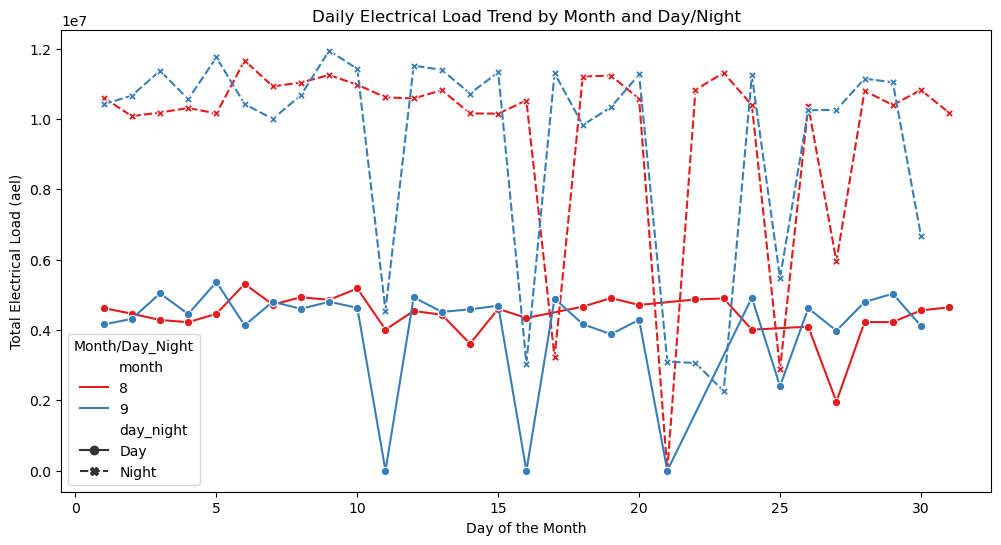

In [41]:
# Convert 'timestamp' to datetime, extract day and month
day_night['timestamp'] = pd.to_datetime(day_night['timestamp'])
day_night['day'] = day_night['timestamp'].dt.day
day_night['month'] = day_night['timestamp'].dt.month


# Assuming you have 'day_night' column in your day_night DataFrame

# Aggregate data by month, day, and day_night
daily_load_day_night = day_night.groupby(['month', 'day', 'day_night'])['ael'].sum().reset_index()

# Plot daily load with month as hue and differentiate by day_night with style
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_load_day_night, x='day', y='ael', hue='month', style='day_night', palette='Set1', markers=True)
plt.title('Daily Electrical Load Trend by Month and Day/Night')
plt.xlabel('Day of the Month')
plt.ylabel('Total Electrical Load (ael)')
plt.legend(title='Month/Day_Night')
plt.show()
